### Random forests

In the last unit, we learned about decision trees and saw that deep trees can lead to overfitting. In this unit, we will see how to solve this issue by combining decision trees into a random forest estimator. We will start by discussing the intuition behind this model and then implement one using Scikit-learn.

ntuition behind random forests
In the unit about the bias-variance trade-off, we saw two typical scenarios that can lead to poor results.

* Having a too simple model that is underfitting (high bias but low variance)
* Having a too complex model that is overfitting (low bias but high variance)

We usually solve the issue by tuning the complexity of the model using grid search. But in some cases, it’s also possible to reduce individually the bias or the variance using ensemble methods such as boosting or bagging.

The idea behind boosting is to chain simple estimators (with a high bias) such that the strengths of each one compensate the weaknesses of the others. That way, we can reduce the overall bias. On the other hand, with bagging, we try to reduce the variance of an estimator by averaging the predictions from several instances of it trained on different samples of the dataset. In this unit, we will learn about random forests which is an example of bagging.

### Scikit-learn implementation
This time, we will work on a synthetic dataset. Scikit-learn provides a make_circles() function to quickly test classification methods using a 2-dimensional toy dataset with two classes. The function generates two nested circles. The outer one contains points from the negative class and the inner one points from the positive class. We can control the distance between each circle with the factor argument and the amount of noise with the noise one.

In [2]:
from sklearn.datasets import make_circles

# Generate circle dataset
X, y = make_circles(n_samples=200, shuffle=True, noise=0.3, random_state=0, factor=0.3)

In this code, we generate a hundred samples from each circle and shuffle the points from the two classes. The function returns an input matrix X with two features and an output vector y with 0/1 values. Let’s now plot the data!

By default, Pyplot uses a slightly larger scale for the x-axis than for the y-axis. Hence, if we plot the data using the default settings, we would get two ellipses instead of two circles. We solve this using the set_aspect() function of the Pyplot Axes object.

Finally, we plot each class separately using the array of booleans class1_idx. You should get the following result:

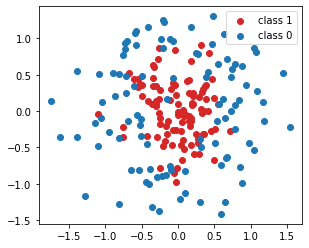

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# Same scale for x- and y-axis
fig, ax = plt.subplots()
ax.set_aspect("equal", adjustable="box")

# Plot data
class1_idx = y == 1
ax.scatter(X[:, 0][class1_idx], X[:, 1][class1_idx], c="C3", label="class 1")
ax.scatter(X[:, 0][~class1_idx], X[:, 1][~class1_idx], c="C0", label="class 0")
ax.legend()
plt.show()

Scikit-learn implements random forests with the RandomForestClassifier estimator. We can pass the number of decision trees in our ensemble with the n_estimators attribute and their maximum depth with the max_depth one.

We can get a single decision tree by setting the number of estimators to one.



In [4]:
from sklearn.ensemble import RandomForestClassifier

# Create a decision tree
dt = RandomForestClassifier(n_estimators=1, max_depth=5, random_state=0)

# Fit estimator
dt.fit(X, y)

RandomForestClassifier(max_depth=5, n_estimators=1, random_state=0)

In this example, our dt estimator corresponds to a decision tree with a depth of five. Let’s visualize it by plotting its decision surface. We provide a decision_surface(ax, x1, x2, y, estimator) in the annex below to do that. The function is very similar to the ones that we used in the previous units. It generates a grid of values in the range of our two input variables x1 and x2, and classifies them using the predict() function from the estimator.

You should get the following result:

In [6]:
import numpy as np

# Helper function
def decision_surface(ax, x1, x2, y, estimator):
    # Same scale for x- and y-axis
    ax.set_aspect("equal", adjustable="box")

    # Plot data points
    class1_idx = y == 1
    plt.scatter(x1[class1_idx], x2[class1_idx], color="C3", label="class 1")
    plt.scatter(x1[~class1_idx], x2[~class1_idx], color="C0", label="class 0")

    # Create a grid of values
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    x_values = np.linspace(*xlim, num=500)
    y_values = np.linspace(*ylim, num=500)
    xx, yy = np.meshgrid(x_values, y_values)
    grid_points = np.c_[xx.flatten(), yy.flatten()]

    # Compute predictions
    preds = estimator.predict(grid_points)
    zz = preds.reshape(xx.shape)

    # Draw decision boundary
    plt.contour(xx, yy, zz, levels=[0.5], colors="gray")

    # Plot decision surface with level curves
    plt.contourf(xx, yy, zz, alpha=0.1, cmap=plt.cm.coolwarm)
    plt.legend()
    plt.show()

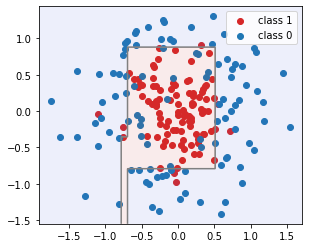

In [7]:
# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, dt)

It seems that a single decision tree with a depth of five is too simple to model our two circles (high bias). Let’s try to remove the limit on its depth by setting max_depth=None.

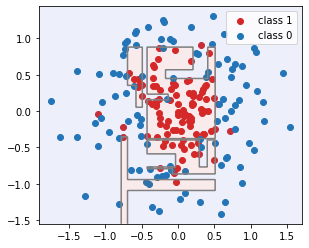

In [8]:
# Create a (deep) decision tree
dt_max_depth = RandomForestClassifier(n_estimators=1, max_depth=None, random_state=0)

# Fit estimator
dt_max_depth.fit(X, y)

# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, dt_max_depth)

This time, the decision surface looks too complicated, and our decision tree is overfitting (high variance). The idea behind random forests is to reduce the variance of our decision tree by combining several instances of it. Let’s start with an ensemble of ten decision trees.

It’s important to understand that each decision tree in our ensemble is different. Remember that we fit each tree to a different bootstrap sample and that each split minimizes impurity among a random subset of the features. By default, the size of this random subset is equal to the square root of the total number of features. 

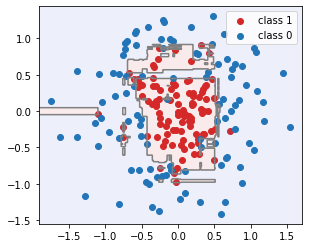

In [9]:
# Create random forest estimator
rf_10 = RandomForestClassifier(n_estimators=10, max_depth=None, random_state=0)

# Fit estimator
rf_10.fit(X, y)

# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, rf_10)

The results already look a bit better with ten decision trees. One of the advantages of decision trees is that they are fast to build and run. Hence, it’s not rare in practice to combine several hundred of decision trees. Let’s try with an ensemble of 200 estimators.



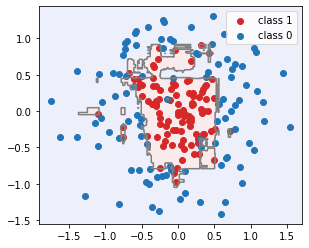

In [10]:
# Create a (large) random forest estimator
rf_200 = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=0)

# Fit estimator
rf_200.fit(X, y)

# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, rf_200)

We can now verify that the ensemble of trees achieves better results than the single tree using cross-validation. Let’s evaluate each estimator using a (stratified) 10-fold cross-validation.



In [11]:
from sklearn.model_selection import cross_validate

# Mean test score of a single decision tree (max depth)
dt_scores = cross_validate(dt_max_depth, X, y, cv=10)
print("Decision tree - mean test {:.3f}".format(np.mean(dt_scores["test_score"])))

# Mean test score of a random forest (200x, max depth)
rf_scores = cross_validate(rf_200, X, y, cv=10)
print("Random forest - mean test {:.3f}".format(np.mean(rf_scores["test_score"])))

Decision tree - mean test 0.780
Random forest - mean test 0.825


The single tree has an average test accuracy of 78% whereas the ensemble achieves a mean accuracy of 82.5%.

#### Note on multiclass vs. multilabel in Scikit-learn

We have already introduced multiclass classification problems in the logistic regression subject. Such problems are characterized by a label y, or a target value, that can take more than two possible options as opposed to binary classification. For example, classifying images of animals into three classes: cat, dog, and horse. In this case, we have a single label per sample with three mutually exclusive classes (which means that a given sample can only belong to one of the three classes).

Let’s now turn into multilabel classifications problems. In such problems, multiple classifications are done at the same time and each sample has more than one label. For example, assume the same set of images as before that we want to classify this time into the following: color of the animal white vs. black, gender of the animal male vs. female, and age of the animal young vs. old. In this case, we have three labels for each sample since we are performing three different classifications. A given sample can be white, female, and old at the same time with y= ["white", “female”, “old”]. One can use binary encoding for each of the three classification problems

This confusion might occur when using Scikit-learn models that support multilabel, such as DecisionTreeClassifier, RandomForestClassifier, and KNeighborsClassifier. In such cases and whenever a multiclass classification is performed, it is recommended to use integer encoding for labels 
y
 instead of one-hot encoding in order to avoid this confusion. Note that LogisticRegressiom only takes integer encoded labels, and no confusion between multiclass and multilabel is expected there.

To illustrate this, let’s use the iris dataset and create a KNeighborsClassifier for the three types of iris flowers.

Let’s start by loading the dataset

In [12]:
from sklearn import datasets

# Load dataset
iris = datasets.load_iris()

# Create X/y arrays
X = iris["data"]
y = iris["target"]

In [13]:
# We then split the data to evaluate our classifier
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

We will now create two types of encodings for the labels y, integer encoding and one-hot encoding



In [14]:
from sklearn.preprocessing import OneHotEncoder

# create one-hot encoder
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

y_tr_hot = encoder.fit_transform(y_tr.reshape(-1, 1))
y_te_hot = encoder.transform(y_te.reshape(-1, 1))

# integer encoded labels
print("Integer-encoded labels:", y_tr[0])

# one-hot encoded labels
print("One-hot encoded labels:", y_tr_hot[0])

Integer-encoded labels: 1
One-hot encoded labels: [0. 1. 0.]


Let’s now train a KNeighborsClassifier using the integer encoded labels

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Create the estimator
knn = KNeighborsClassifier(n_neighbors=2)

# Fit it to train data
knn.fit(X_tr, y_tr)

# output the classes
print("Classes:", knn.classes_)

# Accuracy on test set
accuracy = knn.score(X_te, y_te)
print("Accuracy: {:.3f}".format(accuracy))


Classes: [0 1 2]
Accuracy: 0.978


We will now repeat the same thing but using the one-hot encoded labels and notice the difference in performance

In [16]:
# Create the estimator
knn = KNeighborsClassifier(n_neighbors=2)

# Fit it to train data (using one-hot encoded labels)
knn.fit(X_tr, y_tr_hot)

# output the classes
print("Classes:", knn.classes_)

# Accuracy on test set
accuracy = knn.score(X_te, y_te_hot)
print("Accuracy: {:.3f}".format(accuracy))  # Prints: 0.956

Classes: [array([0., 1.]), array([0., 1.]), array([0., 1.])]
Accuracy: 0.956


You can notice the degradation in accuracy performance by 2%. This is because the Scikit-learn model got confused by the one-hot encoding of 
y and performed multilabel classification (three independent binary classifications in this example) instead of a single multiclass classification. You can notice this by printing the classes_ attribute as done above.

Note that this is a simple example for illustration purposes. In other scenarios, the difference in performance might be much bigger. Therefore, it is essential to distinguish between these two types of classification available in the Scikit-learn library in order to decide which one to use based on the task at hand. For further information on this topic, you can refer to this documentation page.